In [1]:
!pip install spacy

In [2]:
! nvidia-smi

Sat Jan 15 22:59:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Modules for languages
# en_core_web_sm - for English
# it_core_news_sm - for Italian
# es_core_news_sm - for Spanish

!python -m spacy download es_core_news_sm 

     |████████████████████████████████| 16.2 MB 4.6 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=9d6b75219fe7e693edb60911902a5efd434cea59f3d5edd495953d1aee570589
  Stored in directory: /tmp/pip-ephem-wheel-cache-4cmutdmy/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [4]:
import re
import gensim
import glob
import es_core_news_sm
import pandas as pd
import os
import numpy as np

In [6]:
!pip install contractions

     |████████████████████████████████| 284 kB 5.0 MB/s 
     |████████████████████████████████| 321 kB 60.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85444 sha256=1a0e09e5816a9cedad9c93700a6bafc5e6b49c70a5ef83d49dfc8532387d54f4
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [7]:
!pip install unidecode

     |████████████████████████████████| 235 kB 5.1 MB/s 


In [8]:
from datetime import datetime
import codecs
from bs4 import BeautifulSoup
import unidecode
import contractions

In [9]:
def decontracted(phrase):

    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)
    
    #remove html tags from text
    soup = BeautifulSoup(phrase, "html.parser")
    phrase = soup.get_text(separator=" ")
    
    #remove accented characters from text, e.g. café
    phrase = unidecode.unidecode(phrase)
    
    sentences = re.split('([.;!?] *)', phrase)

    return ' '.join([i.capitalize() for i in  sentences])

In [10]:
def prepare_spanish_text(input_path, output_path, error_list,
                         max_len = 5000000, enc = 'utf-8', gutenberg = True, title = ''):
    
    #Spanish pipeline optimized for CPU. 
    #Components: tok2vec, morphologizer, parser, senter, ner, attribute_ruler, lemmatizer.
    
    #parser: The dependency parser jointly learns sentence segmentation and labelled dependency parsing, 
    #and can optionally learn to merge tokens that had been over-segmented by the tokenizer.
    
    nlp = es_core_news_sm.load(disable=['parser'])
    nlp.max_length = max_len
    
    pos_dict = {'PROPN': 'PERSON1', 'PRON': 'PRON1', 'NUM': 'ORDINAL1'}

    
    try:
        raw_text = codecs.open(input_path, 'r', enc).read()
    except:
        return -1
    
    if gutenberg:
        begin = raw_text.find('*** START OF THIS PROJECT GUTENBERG EBOOK ')
        begin_2 = begin + 42 + len(title) + 3
        if begin == -1:
                begin = raw_text.find('START OF THE PROJECT GUTENBERG EBOOK ')
                begin_2 = begin + 37 + len(title) + 3

        end = raw_text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
        if end == -1:
            end = raw_text.find('*** END')
        raw_text = raw_text[begin_2 : end]
        
    
    preprocessed_text = decontracted(raw_text)
    
    nlp_doc = nlp(preprocessed_text)
    sorted_ents = sorted(nlp_doc.ents, key = lambda x: len(x), reverse =  True)


    for ent in sorted_ents:
        preprocessed_text = preprocessed_text.replace(' ' + ent.text + ' ', ' ' + ent.label_+ '1 ')
        
        if not ent.text.islower():
            preprocessed_text = preprocessed_text.replace(' ' + ent.text.lower() + ' ', ' ' + ent.label_+ '1 ')

    new_nlp_doc = nlp(preprocessed_text)
    file_name = path.split('/')[-1]
    

    with open(output_path + file_name, 'w+', ) as prepared_text:
        for token in new_nlp_doc:
            if token.text[-1] != '1':
                if token.pos_ in pos_dict:
                    try:
                        prepared_text.write(pos_dict[token.pos_])
                    except:
                        error_list.append(token.pos_)
                    prepared_text.write('\n')
                    
                        
                    
                elif token.pos_ != 'PUNCT':
                    try:
                        prepared_text.write(token.lemma_.lower())
                    except:
                        error_list.append(token.pos_)
                        
                    prepared_text.write('\n')
                    

            else:
                try:
                    repared_text.write(token.text)
                except:
                        error_list.append(token.pos_)
                prepared_text.write('\n')
    return 1

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataframe

dir_books_es = list(glob.glob("/content/drive/MyDrive/2022-01-15_Course_project/books_es/*.txt"))

In [ ]:
len(dir_books_es)

740

In [ ]:
# Example
dir_books_es[0]

'/content/drive/MyDrive/2022-01-15_Course_project/books_es/10293-8.txt'

In [ ]:
dict_book_es = dict()
num = 0

for book in dir_books_es:
    try:
        with open(book) as f:
            lines = f.read()
    
    except:
        try:
            with open(book, encoding="utf8") as f:
                lines = f.read()
        except:
            try:
                lines = codecs.open(book, 'r', 'ISO-8859-1').read()

        
            except:
                dict_s['length'] = -1
                dict_s['ebook_num'] = book.split("\\")[1].split('.')[0]
                dict_s['ebook_dir'] = book

                dict_s['Title'] = ''
                dict_s['Language'] = ''
                dict_s['encoding'] = ''
                dict_book_en[num] = dict_s
                continue
            
        
        
    info_beg = lines.find('Title: ')
    begin = lines.find('*** START OF THIS PROJECT GUTENBERG EBOOK')
    if begin == -1:
            begin = lines.find('START OF THE PROJECT GUTENBERG EBOOK')
            
    end = lines.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
    if end == -1:
        end = lines.find('*** END')
        
    info = lines[info_beg : begin].split('\n')
    dict_s = dict()
    
    for i in info:
            
        if i.find('Title: ') > -1:
            dict_s['Title'] = i.split('Title: ')[1]
            
        if i.find('Language: ') > -1:
            dict_s['Language'] = i.split('Language: ')[1]
            
        if i.find('Character set encoding: ') > -1:
            dict_s['encoding'] = i.split('Character set encoding: ')[1]
            
    with open(book, 'w', encoding='utf8') as fn:
        fn.write(lines)
             
    dict_s['length'] = len(lines[begin : end].split(' '))
    dict_s['ebook_num'] = book.split("/")[-1].split('.txt')[0]
    dict_s['ebook_dir'] = book
    dict_book_es[num] = dict_s
    num += 1

In [ ]:
file_list = pd.DataFrame(dict_book_es.values())
file_list.head()

,Title,Language,encoding,length,ebook_num,ebook_dir
0,Relacion historica de los sucesos de la rebeli...,Spanish,ISO-8859-1,48418,10293-8,/content/drive/MyDrive/2022-01-15_Course_proje...
1,"Legends, Tales and Poems",English,ISO-8859-1,100941,10814-8,/content/drive/MyDrive/2022-01-15_Course_proje...
2,"Romance de lobos, comedia barbara",Spanish,ISO Latin-1,19825,10506-8,/content/drive/MyDrive/2022-01-15_Course_proje...
3,Los Amantes de Teruel,Spanish,ISO-8859-1,63302,10909-8,/content/drive/MyDrive/2022-01-15_Course_proje...
4,El paraiso de las mujeres,Spanish,ISO Latin-1,81473,10822-8,/content/drive/MyDrive/2022-01-15_Course_proje...


In [12]:
# /content/drive/MyDrive/2022-01-15_Course_project/books_es/
if not os.path.exists('/content/drive/MyDrive/2022-01-15_Course_project/prep_es/'):
    try:
        os.makedirs('/content/drive/MyDrive/2022-01-15_Course_project/prep_es/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [ ]:
print('max length of book: ', max(file_list['length']))

max length of book:  754112


In [13]:
def make_pieces(file_in, file_out, min_lenght = 1000, gutenberg = True, max_count = None):
    file_list = glob.glob(file_in + '*')
    print('number of files: ', len(file_list))
    list_full = []
    list_error = []
    num_ = 0
    count_ = 0
    
    for file_path in file_list:
        try:
            with open(file_path, 'r') as f:
                text = f.read()
    
        except:
            try:
                with open(file_path, 'r', encoding="utf8") as f:
                    text = f.read()
            except:
                try:
                    text = codecs.open(file_path, 'r', 'ISO-8859-1').read()
                except:
                    list_error.append(file_path)
        
            
        if gutenberg:
            info_beg = text.find('Title: ')
            begin = text.find('*** START OF THIS PROJECT GUTENBERG EBOOK ')
            title = ''
            
            if begin > -1:
                for i in text[info_beg : begin].split('\n'):
                    if i.find('Title: ') > -1:
                        title = i.split('Title: ')[1]
                begin_2 = begin + 42 + len(title) + 3
                
            else:
                begin = text.find('START OF THE PROJECT GUTENBERG EBOOK ')
                for i in text[info_beg : begin].split('\n'):
                    if i.find('Title: ') > -1:
                        title = i.split('Title: ')[1]
                begin_2 = begin + 37 + len(title) + 3

            end = text.find('*** END OF THIS PROJECT GUTENBERG EBOOK')
            if end == -1:
                end = text.find('*** END')
            text = text[begin_2 : end]
            
        text_split = text.split('\n')
        len_text =  len(text_split)
        piece_num = len_text // min_lenght
            
        file_name = file_path.split('/')[-1].split('.txt')[0]
        
        if num_ % 500 ==0:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            print(dt_string, '| ',  'number of processed files: ' + str(num_), round(num_/len(file_list), 3))
            
        
        if piece_num > 1:
            for i in range(piece_num -1):
                text_cut = ' '.join([s for s in text_split[i*min_lenght : (i+1)*min_lenght]])
                with open(file_out + file_name + '_piece'+str(i)+'.txt', 'w+') as output_file:
                    try:
                        output_file.write(text_cut)
                    except:
                        list_error.append(file_out + file_name + '_piece'+str(i)+'.txt')
        
        text_cut = ' '.join([s for s in text_split[max(piece_num - 1, 0) * min_lenght : ]])
        with open(file_out + file_name + '_piece'+str(piece_num)+'.txt', 'w+') as output_file:
            try:
                output_file.write(text_cut)
            except:
                list_error.append(file_out + file_name + '_piece'+str(piece_num)+'.txt')
            
        if piece_num ==0:
            list_full.append(file_out + file_name + '_piece'+str(piece_num)+'.txt')
        num_ += 1
        count_ += piece_num
        if max_count is not None:
            if max_count < count_:
                print('create max pieces!', count_, '| last file:', file_path)
                break
    return list_full, list_error

In [ ]:
file_list.sort_values('length', ascending = False)[:20]

,Title,Language,encoding,length,ebook_num,ebook_dir
295,Sagradas Escrituras Version Antigua,Spanish,UTF8,754112,6528-0,/content/drive/MyDrive/2022-01-15_Course_proje...
86,Fortunata y Jacinta,Spanish,ISO-8859-1,358405,17013-8,/content/drive/MyDrive/2022-01-15_Course_proje...
707,Don Quijote,Spanish,UTF-8,354715,2000-0,/content/drive/MyDrive/2022-01-15_Course_proje...
364,Los monfíes de las Alpujarras,Spanish,ISO-8859-1,339499,44584-8,/content/drive/MyDrive/2022-01-15_Course_proje...
674,Historia de América desde sus tiempos más remo...,Spanish,UTF-8,291453,62870-0,/content/drive/MyDrive/2022-01-15_Course_proje...
87,La Regenta,Spanish,ISO-8859-1,279843,17073-8,/content/drive/MyDrive/2022-01-15_Course_proje...
260,El cocinero de su majestad,Spanish,ISO-8859-1,250429,33275-8,/content/drive/MyDrive/2022-01-15_Course_proje...
590,Historia de América desde sus tiempos más remo...,Spanish,ISO-8859-1,249521,57960-8,/content/drive/MyDrive/2022-01-15_Course_proje...
712,Novelas ejemplares y amorosas,Spanish,UTF-8,236182,64465-0,/content/drive/MyDrive/2022-01-15_Course_proje...
398,Historia de la decadencia de España,Spanish,ISO-8859-1,213424,47092-8,/content/drive/MyDrive/2022-01-15_Course_proje...


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = file_list.sort_values('length', ascending = False)['length'].to_list()

In [ ]:
perc_ = np.percentile(x, 99)

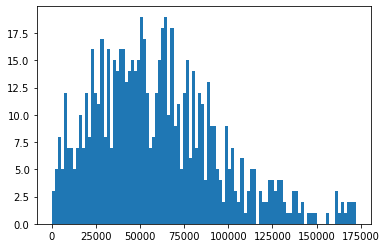

In [ ]:
plt.hist(x[20:], 100)
plt.show()

In [ ]:
sum_len = 0
ind = []
for i in file_list.sort_values('length', ascending = False).index:
    if  file_list.loc[i, 'length'] < perc_:
        sum_len += file_list.loc[i, 'length']
        ind.append(i)
    if sum_len > 20000000:
        break      

In [ ]:
len(ind)

170

In [ ]:
ind_all = [i for i in file_list.sort_values('length', ascending = False).index]

In [ ]:
# Let's process only big files, 
# because there are a lot of small files, which is why processing takes a very long time

tocken_error = []
prepare_book = []

num = 0
book_err = []
sum_len = 0


for i in ind_all:
    if num % 100 == 0:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print(dt_string, '| ',  'number of processed files: ' + str(num), '| count words:', sum_len)
    path = file_list.loc[i, 'ebook_dir']
    
    if file_list.loc[i, 'length'] < perc_ and file_list.loc[i, 'length'] > 1000:
        res = prepare_spanish_text(path, '/content/drive/MyDrive/2022-01-15_Course_project/prep_es/', tocken_error,  max_len = 5000000, 
                                   gutenberg = True, title = file_list.loc[i, 'Title'], enc = file_list.loc[i, 'encoding'])
        if res < 0:
            book_err.append(path)
            print('ERROR: ', path)
        else:
            
            prepare_book.append(path)
            sum_len += file_list.loc[i, 'length']
    num += 1
    if sum_len > 20000000:
        break

15/01/2022 00:14:35 |  number of processed files: 0 | count words: 0
15/01/2022 01:12:34 |  number of processed files: 100 | count words: 12777688


In [15]:
list_not_full , list_error = make_pieces('/content/drive/MyDrive/2022-01-15_Course_project/prep_es/', 
                                         '/content/drive/MyDrive/2022-01-15_Course_project/cut_es/', 
                                         min_lenght = 1500, gutenberg = False, max_count = 150000)

number of files:  170
15/01/2022 23:01:00 |  number of processed files: 0 0.0


In [16]:
len(glob.glob('/content/drive/MyDrive/2022-01-15_Course_project/cut_es/*'))

13774

# TF-IDF  and dictionary

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [28]:
def make_corpus(input_path, output_file_path):
    i = 0
    file_list = glob.glob(input_path + '*')
    
    with open(output_file_path, 'w+') as output_file:
        for file in file_list:
            if i % 100 == 0:
                now = datetime.now()
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                print(dt_string, '| ',  'number of processed files: ' + str(i), '| ', 
                      'percentage of completion:', str(round(i/len(file_list), 2)* 100) + ' %' )
            i+=1
            with open(file, 'r') as input_file:
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [29]:
make_corpus('/content/drive/MyDrive/2022-01-15_Course_project/cut_es/', 
            '/content/drive/MyDrive/2022-01-15_Course_project/spanish_corpus.txt') 

15/01/2022 23:18:43 |  number of processed files: 0 |  percentage of completion: 0.0 %
15/01/2022 23:18:43 |  number of processed files: 100 |  percentage of completion: 1.0 %
15/01/2022 23:18:48 |  number of processed files: 200 |  percentage of completion: 1.0 %
15/01/2022 23:18:48 |  number of processed files: 300 |  percentage of completion: 2.0 %
15/01/2022 23:18:48 |  number of processed files: 400 |  percentage of completion: 3.0 %
15/01/2022 23:18:48 |  number of processed files: 500 |  percentage of completion: 4.0 %
15/01/2022 23:18:49 |  number of processed files: 600 |  percentage of completion: 4.0 %
15/01/2022 23:18:49 |  number of processed files: 700 |  percentage of completion: 5.0 %
15/01/2022 23:18:49 |  number of processed files: 800 |  percentage of completion: 6.0 %
15/01/2022 23:18:49 |  number of processed files: 900 |  percentage of completion: 7.000000000000001 %
15/01/2022 23:18:49 |  number of processed files: 1000 |  percentage of completion: 7.000000000000

In [30]:
def make_table_and_dict(corpus_path, min_df, max_df, token_pattern = None, use_idf = True, stop_words = 'spanish'):
    
    with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df)
        data_vectorized = vectorizer.fit_transform(corpus_file)
    return data_vectorized, vectorizer.get_feature_names(), vectorizer.idf_

In [31]:
es_data_vectorized, es_dictionary, es_idfs = make_table_and_dict('/content/drive/MyDrive/2022-01-15_Course_project/spanish_corpus.txt', 
                                                                 0.01,  0.8,
                                                                 token_pattern = '[A-Za-z]+',
                                                                 stop_words = stopwords.words('spanish'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
len(es_dictionary)

5016

In [33]:
es_data_vectorized.shape

(13774, 5016)

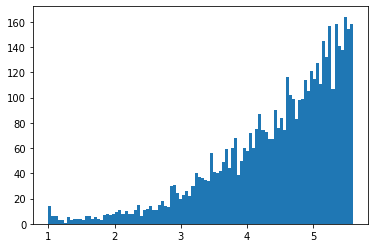

In [34]:
plt.hist(es_idfs, bins = 100)
plt.show()

In [35]:
max(es_idfs)

5.5961367008904235

In [36]:
pairs = list(zip(es_dictionary, es_idfs))
sorted(pairs, key = lambda x: x[1])

[('person', 1.0),
 ('pron', 1.0015983729064075),
 ('lo', 1.0116832289132554),
 ('en', 1.0122709888302568),
 ('ser', 1.0131532769545442),
 ('que', 1.0176503172289446),
 ('el', 1.0198694171853768),
 ('uno', 1.0201656695945944),
 ('por', 1.026258265898282),
 ('los', 1.0281978412918586),
 ('con', 1.0286459703605277),
 ('su', 1.0314138793653829),
 ('ordinal', 1.038933277152992),
 ('del', 1.0424112785419142),
 ('parir', 1.0463575536791503),
 ('comer', 1.0472704483792932),
 ('al', 1.0575214561383632),
 ('este', 1.0577521632567013),
 ('haber', 1.069355913785366),
 ('y', 1.0788939424696629),
 ('hacer', 1.0968067619198025),
 ('n', 1.1079045839026012),
 ('si', 1.116350305698482),
 ('sin', 1.1333758434058439),
 ('tener', 1.1353687029875907),
 ('todo', 1.1358675390471533),
 ('dar', 1.1556884617289878),
 ('otro', 1.1696974035655583),
 ('poder', 1.183120423897699),
 ('entrar', 1.1885404913670379),
 ('decir', 1.1998241089690653),
 ('estar', 1.207745471203088),
 ('sobrar', 1.2443282584697752),
 ('mismo